In [3]:

import os
import pickle

In [4]:
import pandas as pd
import numpy as np

In [5]:
from tslearn.utils import to_time_series_dataset

In [6]:
dirlist = ["2015","2016","2017","2018","2019","2020","2021"]
shpfiles = []
for inputdir in dirlist:
        for dirpath, subdirs, files in os.walk(inputdir+"/"):
            for x in files:
                if x.endswith(".csv"):
                    shpfiles.append(os.path.join(dirpath, x))

In [7]:
weather_data = pd.read_csv("../../WeatherData/GFSEN_WDD_Forecasts.csv",parse_dates=["Trans_INIT_Time"])
time_sep = weather_data["Trans_INIT_Time"].drop_duplicates().reset_index(drop=True).values
cutoff_pair = list(zip(time_sep, time_sep[1:]))

first_period,secound_period = cutoff_pair[::4],cutoff_pair[1::4]
theird_period,fourth_perid = cutoff_pair[2::4],cutoff_pair[3::4]

In [8]:
def nomalize(sequence, method="l1"):
    if method == "True":
        res = [item/sequence[0] for item in sequence]
    elif method == "l2":
        res = [j/i for i, j in zip(sequence[:-1], sequence[1:])]
    return res

In [10]:
def get_value_set(file_list, cutoff_pair, time_flag, use_nomalize=False):
    li = []
    for file_path in file_list:
        data = pd.read_csv(file_path, parse_dates=[
                            "datetime"], index_col="datetime")
        for item in cutoff_pair:
            df = None
            df = data.loc[item[0]:item[1]]
            if item[0].astype(str)[11:19] == time_flag:
                df["time_flag"] = 1
            else:
                df["time_flag"] = 0
            if df is not None:
                li.append(df)
    concat_df = pd.concat(li, axis=0)
    concat_df.dropna(how="any", inplace=True)
    res = concat_df.groupby(['CC_date', pd.Grouper(freq='D')]).agg(list)[
        'vmap'].to_list()
    if use_nomalize:
        res = [nomalize(item, method=use_nomalize)
                for item in res if len(item) > 2]
    return concat_df, to_time_series_dataset(res)

In [9]:
# def get_value_set(file_list, cutoff_pair, use_nomalize=False):
#     data_li, sub_li = [], []
#     for file_path in file_list:
#         data = pd.read_csv(file_path, parse_dates=[
#                            "datetime"], index_col="datetime")
#         data_li.append(data)
        
#     concat_data = pd.concat(data_li, axis=0)
# #     for item in cutoff_pair:
# #         df = None
# #         df = concat_data.loc[item[0]:item[1]]
# #         if df is not None:
# #             sub_li.append(df)
# #     concat_df = pd.concat(sub_li, axis=0)
# #     concat_df.dropna(how="any", inplace=True)
# #     res = concat_df.groupby(['CC_date', pd.Grouper(freq='D')]).agg(list)[
# #         'vmap'].to_list()
# #     if use_nomalize:
# #         res = [nomalize(item, method=use_nomalize)
# #                for item in res if len(item) > 2]
#     return concat_data
# #to_time_series_dataset(res)

In [11]:
from datetime import datetime, timedelta

In [12]:
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M')

In [13]:
def normalize_time(series):
    series = pd.to_datetime(series, format="%H:%M:%S").to_series()
    
    series += pd.to_timedelta(series.lt(series.shift()).cumsum(), unit="D")
    #print(series)
    return series.values

In [14]:
import seaborn as sns
import matplotlib

In [19]:
period_dict = {"first_period":first_period, 'secound_period':secound_period, 'theird_period':theird_period}
period_date = {"first_period":"00:28:00-06:28:00", 'secound_period':"06:28:00-12:28:00", 'theird_period':"12:28:00"}

In [ ]:
weather_data.set_index("Trans_INIT_Time",inplace=True)

## Clustering

In [15]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [16]:
def save_clustering_fig(dba_km, n_clusters, y_pred, period_data, file_name):
    plot_count = math.ceil(math.sqrt(n_clusters))
    #cluster_count = math.ceil(math.sqrt(len(mySeries)))
    fig, axs = plt.subplots(plot_count, plot_count, figsize=(20, 20))
    #fig.suptitle('First period')
    row_i = 0
    column_j = 0
    
    
    for label in set(y_pred):
        cluster = []
        for i in range(len(y_pred)):
            if(y_pred[i] == label):
                axs[row_i, column_j].plot(period_data[i], color=[
                                          0.7, 0.8, 0.8], alpha=0.4)
                cluster.append(first_period[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(dba_km.cluster_centers_[
                                      label].ravel(), color="red")

        axs[row_i, column_j].set_title(
            "Cluster "+str(row_i*plot_count+column_j))
        column_j += 1
        if column_j % plot_count == 0:
            row_i += 1
            column_j = 0

In [17]:
def fit_data(n_cluster, period_data, period_df, file_name, method="dba", use_nomalize=False):
    if method == "dba":
        seed = 13
        dba_km = TimeSeriesKMeans(n_clusters=n_cluster,
                                  metric="dtw",
                                  n_jobs=8,
                                  max_iter_barycenter=10,
                                  verbose=False,
                                  n_init=2,
                                  random_state=seed)
        y_pred = dba_km.fit_predict(period_data)
        sava_path = "dba_"+file_name+"_"+str(n_cluster)+"_"+str(use_nomalize)
        # print(sava_path)
        dba_km.to_pickle(sava_path+".pkl")
        save_clustering_fig(dba_km=dba_km, n_clusters=n_cluster,
                            y_pred=y_pred, period_data=period_data,period_df=period_df,file_name=sava_path)

In [110]:
for period in list(period_dict.keys())[2:]:
    for normal in ["True", ]:
        if period == "first_period":
            time_flag = "01:28:00"
            model_path = "../K-means/first_period/models/dba_first_period_16_True.pkl"
        elif period == "secound_period":
            time_flag = "07:28:00"
            model_path = "../K-means/secound_period/models/dba_secound_period_16_True.pkl"
        elif period == "theird_period":
            time_flag = "13:28:00"
            model_path = "../K-means/theird_period/models/dba_theird_period_16_True.pkl"
        period_df, period_data = get_value_set(
            shpfiles, period_dict[period],time_flag=time_flag, use_nomalize=normal)
        model = TimeSeriesKMeans.from_pickle(model_path)
        y_pred = model.predict(period_data)
        
        res = get_cluster_time_set(model, y_pred, period_df) 
        
#         save_clustering_fig(dba_km=model,
#                             y_pred=y_pred,
#                             n_clusters=16,
#                             file_name=model_path[:-4],
#                             period_data=period_data,
#                             period_df=period_df)
        

        
#         for clu_n in tqdm([2, 3, 4, 8, 12, 14]):
#             # for clu_n in tqdm([8, 12, 14]):
#             # print(len(period_data))
#             # print()
#             y_pred = fit_data(n_cluster=clu_n, period_data=period_data,
#                               file_name=period, use_nomalize=normal)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [ ]:
for label in res.keys():
    li = []
    for item in res[label]:
        li.append(weather_data[weather_data.index.isin(item)])
    concat_df = pd.concat(li, axis=0) 
    
    concat_df = concat_df.loc[concat_df.index.strftime("%H:%M:%S") <= "16:00:00"]
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 20))
    
    row_i = 0
    column_j = 0
    
    file_name = " ".join([period_date.get(period), "Cluster:",  str(label+1)])

    fig.suptitle(file_name)

    for PARAM in ["CDD","HDD"]:
        sub_df = concat_df[concat_df["PARAM"] == PARAM]
        for item in ["Sum_Value","Delta_Sub","Delta_Full"]:
            sns.distplot(sub_df[item], rug=True, rug_kws={"color": "g"},
                          kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                          hist_kws={"histtype": "step", "linewidth": 3,
                                    "alpha": 1, "color": "g"}, ax=axs[row_i, column_j])
            axs[row_i, column_j].set_title(PARAM)

            column_j += 1
            if column_j % 3 == 0:
                row_i += 1
                column_j = 0

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    plt.savefig("_".join([period,"cluster",str(label+1)])+".png", dpi=200,
                    bbox_inches="tight", orientation='landscape')

    #plt.show()
        #sns.lineplot(x="index",y="data", data = center_df, color="red", ax=axs[row_i, column_j])

In [215]:
def show_distribution(concat_df,file_name):
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 20))
    
    row_i = 0
    column_j = 0
    
    file_name = " ".join(file_name)

    fig.suptitle(file_name)

    for PARAM in ["CDD","HDD"]:
        sub_df = concat_df[concat_df["PARAM"] == PARAM]
        for item in ["Sum_Value","Delta_Sub","Delta_Full"]:
            sns.distplot(sub_df[item], rug=True, rug_kws={"color": "g"},
                          kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                          hist_kws={"histtype": "step", "linewidth": 3,
                                    "alpha": 1, "color": "g"}, ax=axs[row_i, column_j])
            axs[row_i, column_j].set_title(PARAM)

            column_j += 1
            if column_j % 3 == 0:
                row_i += 1
                column_j = 0

    fig.tight_layout()
    
    fig.subplots_adjust(top=0.95)
    
    plt.savefig("_".join(file_name)+".png", dpi=200,
                    bbox_inches="tight", orientation='landscape')

In [23]:
def get_cluster_time_set(dba_km, y_pred, period_df):
    
    time_dict = {}
                        
    for label in set(y_pred):
        i = 0
        time_set = []
        for _, d in period_df.groupby(['CC_date', pd.Grouper(freq='D')]):
            if len(d) > 2:
                if(y_pred[i] == label):
                    time_set.append(d.index)
                i += 1
        time_dict.update({label:time_set})
    return time_dict
    

In [199]:
import math
def save_clustering_fig(dba_km, n_clusters, y_pred, period_data, period_df,ci_df, file_name):
    plot_count = math.ceil(math.sqrt(n_clusters))
        #cluster_count = math.ceil(math.sqrt(len(mySeries)))
    fig, axs = plt.subplots(plot_count, plot_count, figsize=(20, 20))
    #fig.suptitle('First period')
    row_i = 0
    column_j = 0
    max_len_index = 0
    max_index = None
    
    for _, d in period_df.groupby(['CC_date', pd.Grouper(freq='D')]):
            if len(d) > 2:
                    d["normal_vmap"] = nomalize(d["vmap"].values, method="True")
                    data_index = d.index
                    if d["time_flag"][0] == 1:
                        data_index = data_index + timedelta(hours=-1,minutes=0)
                    d["Time"] = normalize_time(data_index.time)
                    if len(d["Time"]) > max_len_index:
                        max_len_index = len(d["Time"])
                        max_index = d["Time"]  
    
    for label in set(y_pred):
        i = 0
        for _, d in period_df.groupby(['CC_date', pd.Grouper(freq='D')]):
            if len(d) > 2:
                if(y_pred[i] == label):
                    d["normal_vmap"] = nomalize(d["vmap"].values, method="True")
                    data_index = d.index
                    color = [0.7, 0.8, 0.8]
                    if d["time_flag"][0] == 1:
                        data_index = data_index + timedelta(hours=-1,minutes=0)
                        color = [1, 0.96, 0.56]
                    d["Time"] = normalize_time(data_index.time) 

                    sns.lineplot(x="Time",y="normal_vmap", data = d, color=color, ax=axs[row_i, column_j])
                i+=1
        print((len(max_index.values),(len(dba_km.cluster_centers_[label].ravel()))))
        center_df = pd.DataFrame({"index":max_index.values,"data":dba_km.cluster_centers_[label].ravel()})
        sns.lineplot(x="index",y="data", data = center_df, color="red", ax=axs[row_i, column_j])

        axs[row_i, column_j].set_title(
            "Cluster "+str(row_i*plot_count+column_j))
        axs[row_i, column_j].xaxis.set_major_formatter(
            matplotlib.dates.DateFormatter("%H:%M")
        )
        
        query_res = []
        for param in ["CDD","HDD"]:
            for item in ["Sum_Value","Delta_Sub","Delta_Full"]:
                ci_query = ci_df.round(2).query(f"period == '{period}' & label == {label} & Param=='{param}' & fe=='{fe}'")[["Param","fe","left_ci","right_ci"]].iloc[0].to_dict()
                ci_query.update({"ci":[ci_query["left_ci"],ci_query["right_ci"]]})
                for key in ['left_ci', 'right_ci']:
                        ci_query.pop(key)
                query_res.append("\n".join("{}: {}".format(*i) for i in ci_query.items()))
        
        query_i = 0        
        for item in np.arange(0.05, 0.95, 0.15).tolist():
            axs[row_i, column_j].text(1.05, item ,query_res[query_i],
                    size=14,
                    bbox=dict(edgecolor='lightgreen', facecolor='none', pad=3, linewidth=1),
                    ha='left', va='center', transform=ax.transAxes)
            query_i += 1
        
        
        column_j += 1
        if column_j % plot_count == 0:
            row_i += 1
            column_j = 0
    plt.savefig(file_name+".png", dpi=200,
                bbox_inches="tight", orientation='landscape')

## Confience interval

In [26]:
from scipy.stats import bernoulli, norm, t, skewnorm
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


(666, 361)


ValueError: All arrays must be of the same length

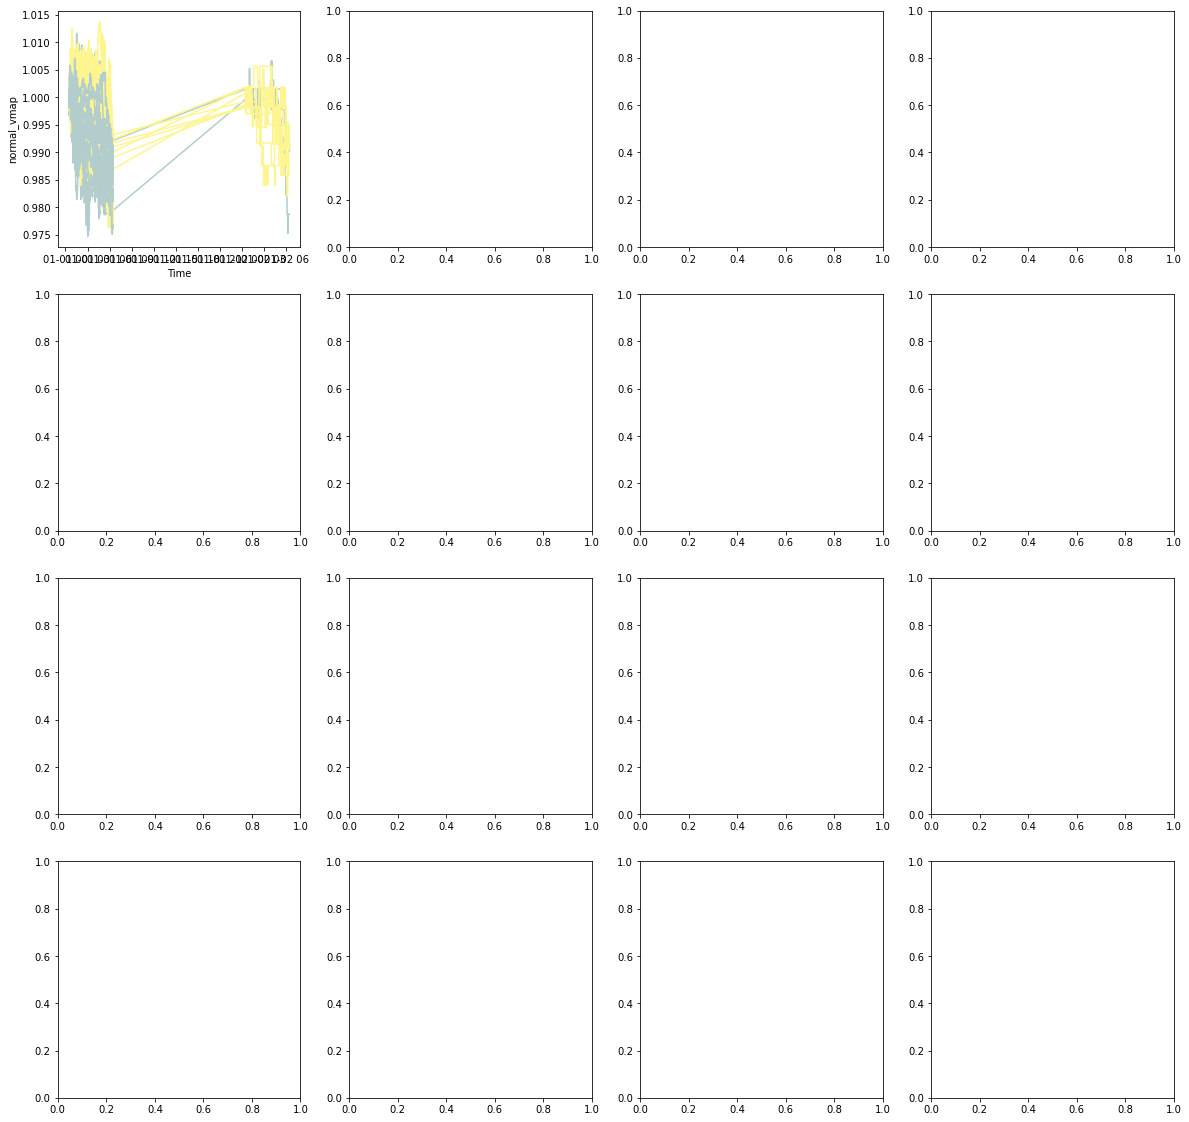

In [200]:

for period in list(period_dict.keys()):
    for normal in ["True", ]:
        if period == "first_period":
            time_flag = "01:28:00"
            model_path = "../K-means/first_period/models/dba_first_period_16_True.pkl"
        elif period == "secound_period":
            time_flag = "07:28:00"
            model_path = "../K-means/secound_period/models/dba_secound_period_16_True.pkl"
        elif period == "theird_period":
            time_flag = "13:28:00"
            model_path = "../K-means/theird_period/models/dba_theird_period_16_True.pkl"
        period_df, period_data = get_value_set(
            shpfiles, period_dict[period],time_flag=time_flag, use_nomalize=normal)
        model = TimeSeriesKMeans.from_pickle(model_path)
        y_pred = model.predict(period_data)
        
        res = get_cluster_time_set(model, y_pred, period_df)
        
        ci_data = []
        for label in res.keys():
            li = []
            for item in res[label]:
                li.append(weather_data[weather_data.index.isin(item)])
            concat_df = pd.concat(li, axis=0)
            concat_df = concat_df.loc[concat_df.index.strftime("%H:%M:%S") <= "16:00:00"]

            for PARAM in ["CDD","HDD"]:
                for fe in ["Sum_Value","Delta_Sub","Delta_Full"]: 
                    sub_df = concat_df[concat_df["PARAM"] == PARAM]
                    
                    left_ci , right_ci = get_confidence_interbval(sub_df[fe].values)
                    ci_data.append((label,PARAM,fe,left_ci,right_ci))
        
        ci_df = pd.DataFrame(ci_data,columns=["label", "Param", "fe", "left_ci", "right_ci"])
        
        save_clustering_fig(dba_km=model,
                    y_pred=y_pred,
                    n_clusters=16,
                    file_name=model_path[:-4],
                    period_data=period_data,
                    period_df=period_df,
                    ci_df=ci_df )
        

In [2]:
def get_confidence_interbval(sample, ci=0.95):
    
    x_hat = np.mean(sample)
    n = len(sample)
    z_hat = norm.ppf(ci+(1-ci)/2)*np.std(sample)/np.sqrt(n)
    
    return x_hat-z_hat, x_hat+z_hat

In [203]:
ci_df

,label,Param,fe,left_ci,right_ci
0,0,CDD,Sum_Value,30.990187,42.831307
1,0,CDD,Delta_Sub,-0.145058,0.091877
2,0,CDD,Delta_Full,-0.133588,0.167874
3,0,HDD,Sum_Value,223.031731,258.680606
4,0,HDD,Delta_Sub,-1.097433,0.093082
...,...,...,...,...,...
91,15,CDD,Delta_Sub,-0.351692,0.401692
92,15,CDD,Delta_Full,-0.240151,0.680151
93,15,HDD,Sum_Value,200.034153,355.170847
94,15,HDD,Delta_Sub,-3.822855,2.241189


In [206]:
ci_sub_query = ci_df.round(2).query(f"Param=='CDD' & fe=='Sum_Value'")[["left_ci", "right_ci"]]
#.iloc[0].to_dict()

In [209]:
SE_hat_x_list = list(ci_sub_query.itertuples(index=False,name=None))

In [210]:
[(x[0]+x[1])/2 for x in SE_hat_x_list]

[36.91,
 55.650000000000006,
 59.235,
 49.9,
 4.19,
 70.86,
 26.845,
 46.07,
 63.365,
 45.394999999999996,
 64.21000000000001,
 68.82,
 34.86,
 48.254999999999995,
 1.54,
 15.89]

In [211]:
SE_hat_x_list

[(30.99, 42.83),
 (47.63, 63.67),
 (44.61, 73.86),
 (38.86, 60.94),
 (4.15, 4.23),
 (64.53, 77.19),
 (6.55, 47.14),
 (30.74, 61.4),
 (56.34, 70.39),
 (37.74, 53.05),
 (44.7, 83.72),
 (62.89, 74.75),
 (23.77, 45.95),
 (37.26, 59.25),
 (0.2, 2.88),
 (9.18, 22.6)]

In [ ]:
f"Param=='{param}' & fe=='{fe}'"

In [214]:
def show_confidence_interval(ci_df, query_str , filename):
        
        ci_sub_query = ci_df.round(2).query(query_str)[["left_ci", "right_ci"]]
        
        SE_hat_x_list = list(ci_sub_query.itertuples(index=False,name=None))
        
        x_hat_list = [(x[0]+x[1])/2 for x in SE_hat_x_list]
        
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 8))
        for i in range(len(x_hat_list)):
            ax.errorbar(x_hat_list[i], np.arange(len(x_hat_list))[i],lolims=True, xerr=SE_hat_x_list[1]-x_hat_list[i], yerr=0.0, linestyle='', c='black')
    
        fig.suptitle(" ".join(filename))

        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        plt.savefig("_".join(filename)+".png", dpi=200,
                        bbox_inches="tight", orientation='landscape')

In [73]:
def confidence_interval_mean(sample_set, filename, ci=0.9):
    x_hat_list = []
    SE_hat_x_list = []
    
    confidence_interval_set = []
    
    for s_ in sample_set :
        
        x_hat = np.mean(s_)
        x_hat_list.append(x_hat)
        n = len(s_)
        z_hat = norm.ppf(ci+(1-ci)/2)*np.std(s_)/np.sqrt(n)
        SE_hat_x_list.append(z_hat)
        
        confidence_interval_set.append((x_hat-z_hat, x_hat+z_hat))
        #print(confidence_interval_set)

    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    for i in range(len(x_hat_list)):
            ax.errorbar(x_hat_list[i], np.arange(len(x_hat_list))[i],lolims=True, xerr=SE_hat_x_list[i], yerr=0.0, linestyle='', c='black')
    
    fig.suptitle(" ".join(filename))

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    plt.savefig("_".join(filename)+".png", dpi=200,
                    bbox_inches="tight", orientation='landscape')
    
    return confidence_interval_set
    #print(f'{j}/{number_trials}={np.round(j/number_trials,2)}')

[(3.3131315841577864, 6.686868415842214)]


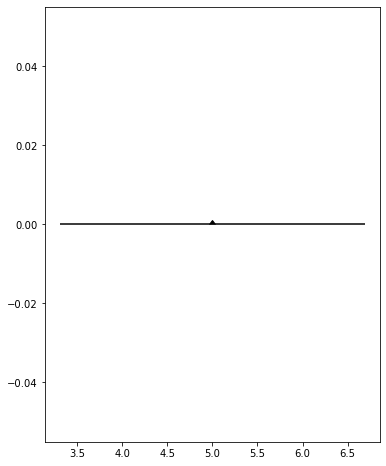

[(3.3131315841577864, 6.686868415842214)]

In [42]:
confidence_interval_mean([sample])

Text(1.05, 0.5, 'name: hh \nsex:ss \nsfs:sdf')

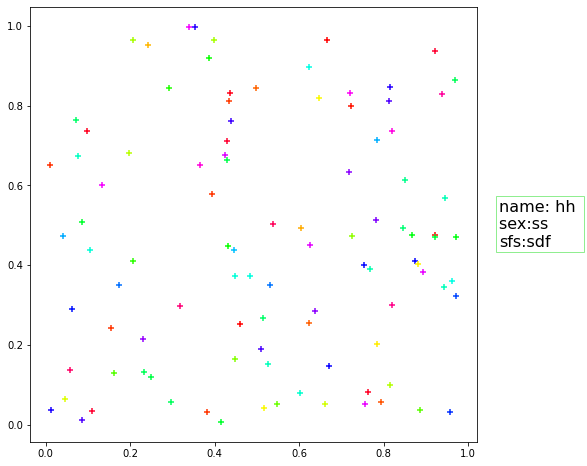

In [69]:
period = 'first_period'
label=0
param='CDD'
fe='Sum_Value'

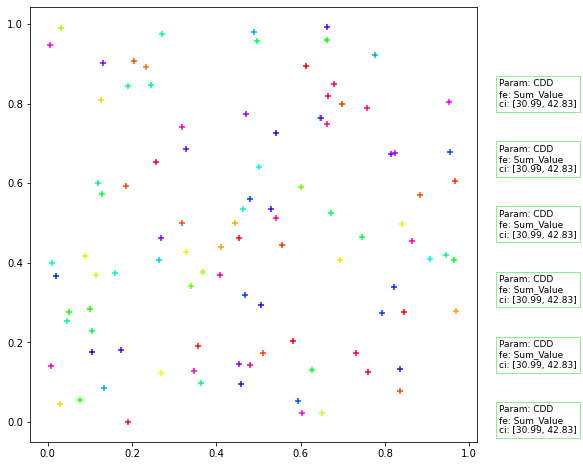

In [197]:
ci_query = ci_df.round(2).query(f"period == '{period}' & label == {label} & Param=='{param}' & fe=='{fe}'")[["Param","fe","left_ci","right_ci"]].iloc[0].to_dict()
ci_query.update({"ci":[ci_query["left_ci"],ci_query["right_ci"]]})
for key in ['left_ci', 'right_ci']:
        ci_query.pop(key)
res = "\n".join("{}: {}".format(*i) for i in ci_query.items())

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(np.random.rand(100), np.random.rand(100),
           marker='+', c=np.random.rand(100),
           cmap='hsv')
for item in   np.arange(0.05, 0.95, 0.15).tolist():
    ax.text(1.05, item ,res,
            size=9,
            bbox=dict(edgecolor='lightgreen', facecolor='none', pad=3, linewidth=1),
            ha='left', va='center', transform=ax.transAxes)

KeyError: 'left_ci'

In [186]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [189]:
 np.arange(0.05, 0.95, 0.15).tolist()

[0.05,
 0.2,
 0.35000000000000003,
 0.5000000000000001,
 0.6500000000000001,
 0.8000000000000002]